# Direct Ptychography Tutorial 02

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ophusgroup/apmc2025-4dstem-workshop/blob/main/notebooks/try-it-yourself/05.direct_ptychography_02.ipynb)

This is the second tutorial notebook in the direct ptychography series.  
In this tutorial notebook we will cover:
- Single side band (SSB) reconstructions with known aberrations
- Recursive aberration-fitting using the complex probe overlap function

### Downloads
This tutorial uses the following datasets:
- [dpc_STO_simulation_aberrated.h5](https://drive.google.com/file/d/1naukh3S54nvR-lkAH756ILEvs2JVXEyS/view?usp=sharing)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (cophus@stanford.edu)

Last updated: 2025 Feb 01

## Introduction

The previous tutorial used an in-focus simulated dataset, to introduce the SSB and WDD algorithms.  
In practice, as hard as we try and correct aberrations on the microscope -- our probe will have some residual aberrations.

In [1]:
%pip install py4DSTEM > /dev/null 2>&1

In [2]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)
%matplotlib inline

cupyx.jit.rawkernel is experimental. The interface can change in the future.


0.14.18


We load the dataset, which is very similar to the previous tutorial, but simulated using an aberrated probe.

In [3]:
# Get the 4DSTEM data
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1naukh3S54nvR-lkAH756ILEvs2JVXEyS',
    destination = '/content/',
    filename = 'dpc_STO_simulation_aberrated.h5',
    overwrite=True
)

Downloading...
From: https://drive.google.com/uc?id=1naukh3S54nvR-lkAH756ILEvs2JVXEyS
To: /content/dpc_STO_simulation_aberrated.h5
100%|██████████| 75.5M/75.5M [00:00<00:00, 91.0MB/s]


In [4]:
file_path = '/content/'
file_data = file_path + 'dpc_STO_simulation_aberrated.h5'

dataset = py4DSTEM.read(file_data)
dataset

DataCube( A 4-dimensional array of shape (32, 32, 96, 96) called 'datacube',
          with dimensions:

              Rx = [0.0,0.12328531250000001,0.24657062500000002,...] A
              Ry = [0.0,0.12328531250000001,0.24657062500000002,...] A
              Qx = [0.0,1.0595062826244177,2.1190125652488354,...] mrad
              Qy = [0.0,1.0595062826244177,2.1190125652488354,...] mrad
)

## Effect of aberrations

First, let's try and reconstruct like before -- to see the effect of aberrations on the reconstruction:

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 29548.53probe position/s]
Best fit rotation forced to -15 degrees.
Normalizing amplitudes: 100%|██████████| 1024/1024 [00:01<00:00, 794.00probe position/s]


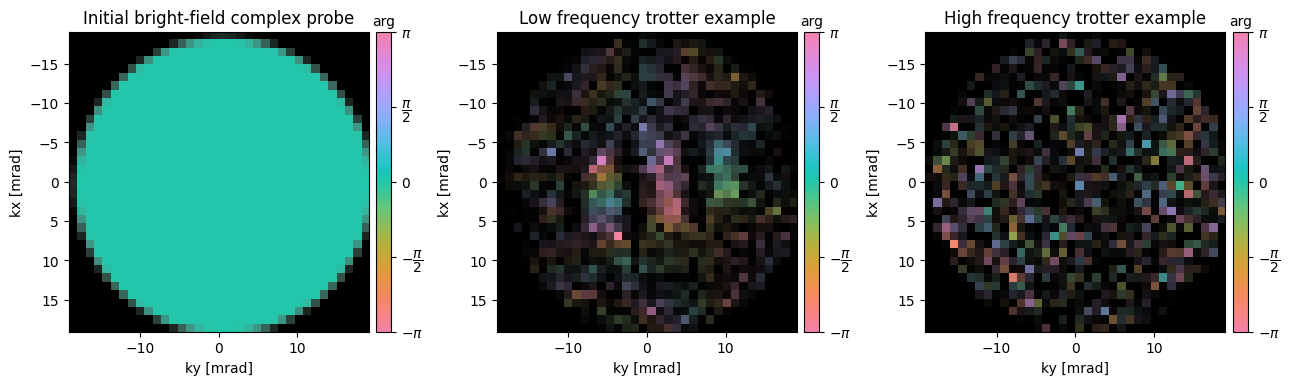

In [5]:
energy = 200e3
semiangle_cutoff = 20

ssb = py4DSTEM.process.phase.SSB(
    energy=energy,
    datacube=dataset,
    semiangle_cutoff=semiangle_cutoff,
    verbose=True,
).preprocess(
    plot_center_of_mass=False,
    plot_rotation=False,
    force_com_rotation=-15,
    vectorized_com_calculation=False,
)

First, notice that our complex overlap trotters look quite different! Notably:
- The phase inside each trotter is not flat, but rather seems to have texture
- The triple-overlap region is no-longer cancelled out

100%|██████████| 1024/1024 [00:01<00:00, 1136.31it/s]


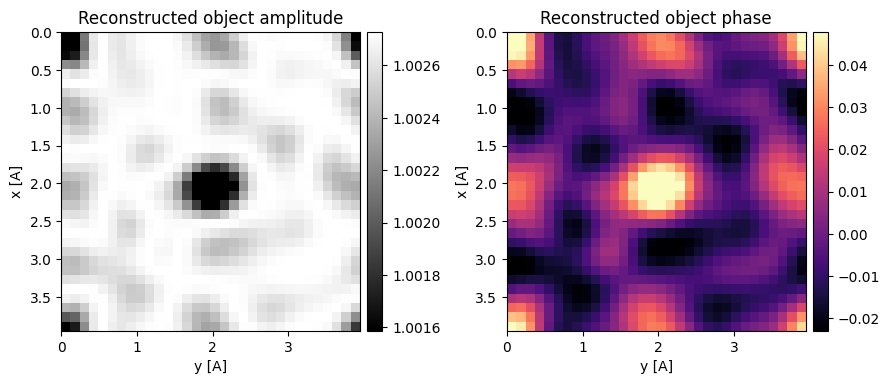

In [6]:
ssb = ssb.reconstruct(
).visualize(
)

reconstructed_object_aberrated = ssb.object.copy()

As we expected, the reconstructed object has all-sorts of artifacts.

### Optional: Try and correct the aberrations manually!

If you're feeling brave (and have `ipywidgets` installed), try correcting the aberrations manually!

In [8]:
# import ipywidgets
# from IPython.display import display

# def widget_wrapper(
#     defocus,
#     stig,
#     stig_angle,
#     coma,
#     coma_angle,
#     trefoil,
#     trefoil_angle
# ):
#     ssb._verbose = False
#     ssb.reconstruct(
#         polar_parameters={'C10':-defocus,'C12':stig,'phi12':np.deg2rad(stig_angle),'C21':coma,'phi21':np.deg2rad(coma_angle),'C23':trefoil,'phi23':np.deg2rad(trefoil_angle)},
#         progress_bar=False,
#         num_jobs=1,
#     ).visualize(
#     )
#     ssb._verbose = True

# style = {'description_width': 'initial'}
# layout = ipywidgets.Layout(width="400px",height="30px")
# kwargs = {'style':style,'layout':layout,'continuous_update':False}

# defocus_slider = ipywidgets.FloatSlider(value = 0,min = -100,max = 100, description = "defocus [Å]",**kwargs)
# stig_slider = ipywidgets.FloatSlider(value = 0,min = 0,max = 100, description = "stig [Å]",**kwargs)
# stig_angle_slider = ipywidgets.FloatSlider(value = 0,min = 0,max = 90, description = "stig angle [°]",**kwargs)
# coma_slider = ipywidgets.FloatSlider(value = 0,min = 0,max = 10000, description = "coma [Å]",**kwargs)
# coma_angle_slider = ipywidgets.FloatSlider(value = 0,min = 0,max = 180, description = "coma angle [°]",**kwargs)
# trefoil_slider = ipywidgets.FloatSlider(value = 0,min = 0,max = 10000, description = "trefoil [Å]",**kwargs)
# trefoil_angle_slider = ipywidgets.FloatSlider(value = 0,min = 0,max = 60, description = "trefoil angle [°]",**kwargs)

# def set_solution(*args):
#     defocus_slider.value, stig_slider.value, coma_slider.value, trefoil_slider.value,trefoil_angle_slider.value = (100,0,0,10000,27.5)

# solutions_button = ipywidgets.Button(description='reveal solution!',**kwargs)
# solutions_button.on_click(set_solution)

# output = ipywidgets.interactive_output(
#     widget_wrapper,
#     {
#         'defocus':defocus_slider,
#         'stig':stig_slider,
#         'stig_angle':stig_angle_slider,
#         'coma':coma_slider,
#         'coma_angle':coma_angle_slider,
#         'trefoil':trefoil_slider,
#         'trefoil_angle':trefoil_angle_slider,
#     }
# )

# display(
#     ipywidgets.VBox(
#         [
#             ipywidgets.HBox([defocus_slider,solutions_button]),
#             ipywidgets.HBox([stig_slider,stig_angle_slider]),
#             ipywidgets.HBox([coma_slider,coma_angle_slider]),
#             ipywidgets.HBox([trefoil_slider,trefoil_angle_slider]),
#             output
#         ]
#     )
# )

## Known aberrations reconstructions

Note that similar to how we deconvolved the geometric effects of the probe in the first tutorial, if we know our probe aberrations we can also account for them:

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 15993.47probe position/s]
Best fit rotation forced to -15 degrees.
Normalizing amplitudes: 100%|██████████| 1024/1024 [00:02<00:00, 464.32probe position/s]


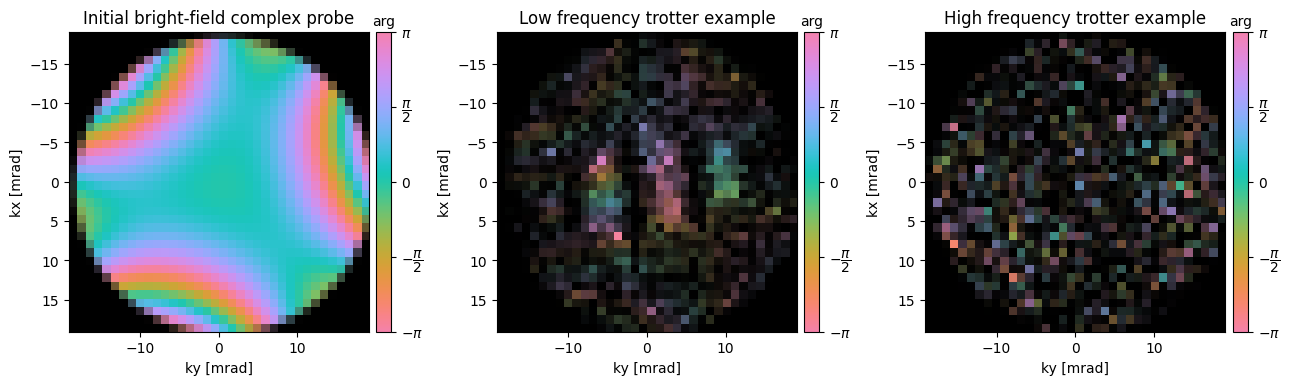

In [9]:
ssb_known = py4DSTEM.process.phase.SSB(
    energy=energy,
    datacube=dataset,
    semiangle_cutoff=semiangle_cutoff,
    C10=-100,C23=10000,phi23=np.deg2rad(27.5),
    verbose=True,
).preprocess(
    plot_center_of_mass=False,
    plot_rotation=False,
    force_com_rotation=-15,
    vectorized_com_calculation=False,
)

100%|██████████| 1024/1024 [00:01<00:00, 1000.33it/s]


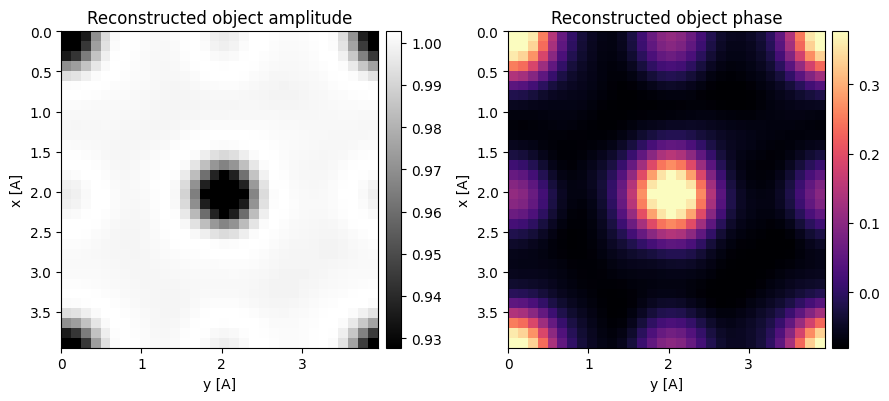

In [10]:
ssb_known = ssb_known.reconstruct(
).visualize(
)

reconstructed_object_known = ssb_known.object.copy()

## Estimating aberrations

Our task therefore reduces to estimating the probe aberrations from the dataset directly. Once we know them, we can proceed as usual!  
In the `parallax_02.ipynb` tutorial, we demonstrate one way of doing so using the apparent shifts in virtual bright-field images.  
Here, we demonstrate another way by fitting the texture in the complex probe overlaps directly, following [10.1038/ncomms12532](https://www.nature.com/articles/ncomms12532).

In particular, we'll select the 12 trotters with the highest intensity, and fit a basis function of specified order:

          Fitted aberration coefficients          
--------------------------------------------------
aberration    radial   angular   angle   magnitude
   name       order     order    [deg]     [Ang]  
----------   -------   -------   -----   ---------
    C1          2         0       ---      -102   
   stig         2         2      -82.9      12    
   coma         3         1      119.3     5560   
 trefoil        3         3      25.9      11603  


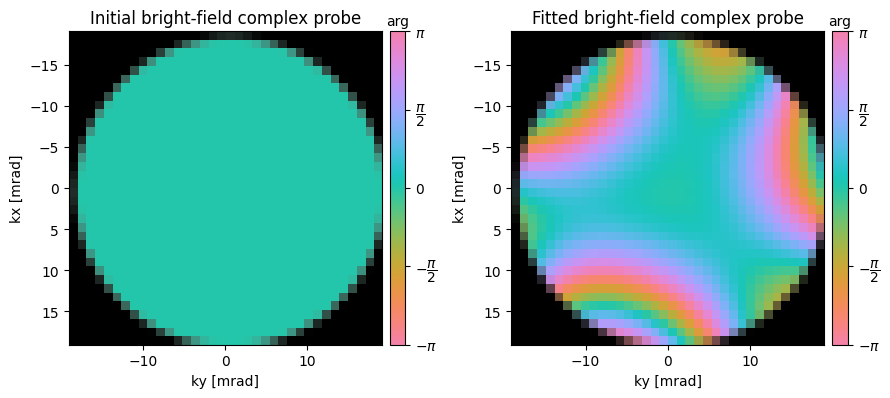

In [19]:
ssb = ssb.aberration_fit(
    num_trotters=18,
    max_radial_order=3,
    method='global',
)

100%|██████████| 1024/1024 [00:00<00:00, 1278.31it/s]


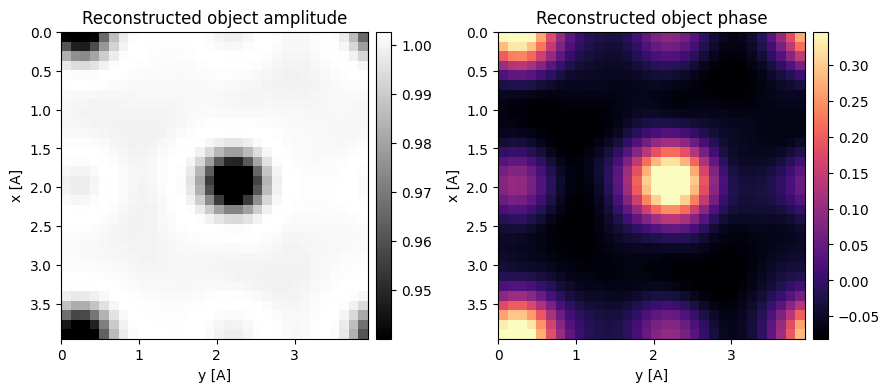

In [20]:
ssb = ssb.reconstruct(
    # polar_parameters=ssb._fitted_polar_parameters, # this is implied when aberration_fit() has ran
).visualize(
)

reconstructed_object_fitted = ssb.object.copy()

## Recursive fitting

The fitting procedure above performed quite well! For noisier datasets, it is often useful to fit the aberration coefficients recursively, i.e.:
- Iteration 1: defocus, stig
- Iteration 2: defocus, stig, coma, trefoil
- Iteration 3: defocus, stig, coma, trefoil, spherical, stig2, quadrafoil,
- Iteration 4: ...

          Fitted aberration coefficients          
--------------------------------------------------
aberration    radial   angular   angle   magnitude
   name       order     order    [deg]     [Ang]  
----------   -------   -------   -----   ---------
    C1          2         0       ---      -113   
   stig         2         2      -73.3       8    
   coma         3         1      121.1     5412   
 trefoil        3         3      25.5      12132  


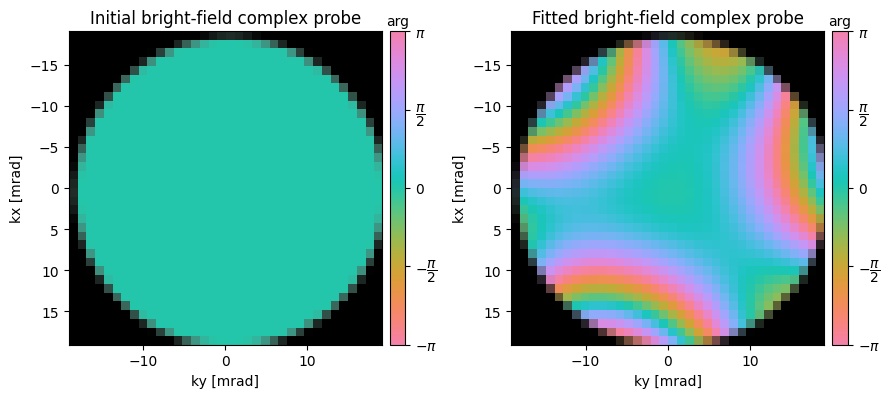

In [21]:
ssb = ssb.aberration_fit(
    num_trotters=12,
    max_radial_order=3,
    method='recursive',
)

100%|██████████| 1024/1024 [00:00<00:00, 1201.73it/s]


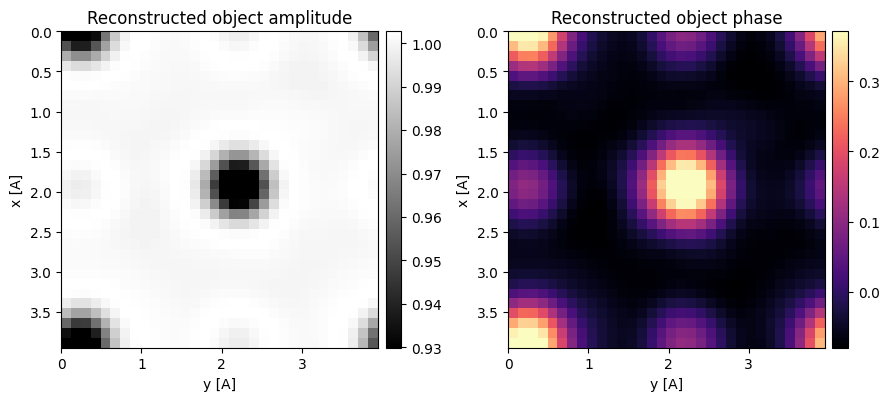

In [22]:
ssb = ssb.reconstruct(
).visualize(
)

reconstructed_object_fitted_recursive = ssb.object.copy()

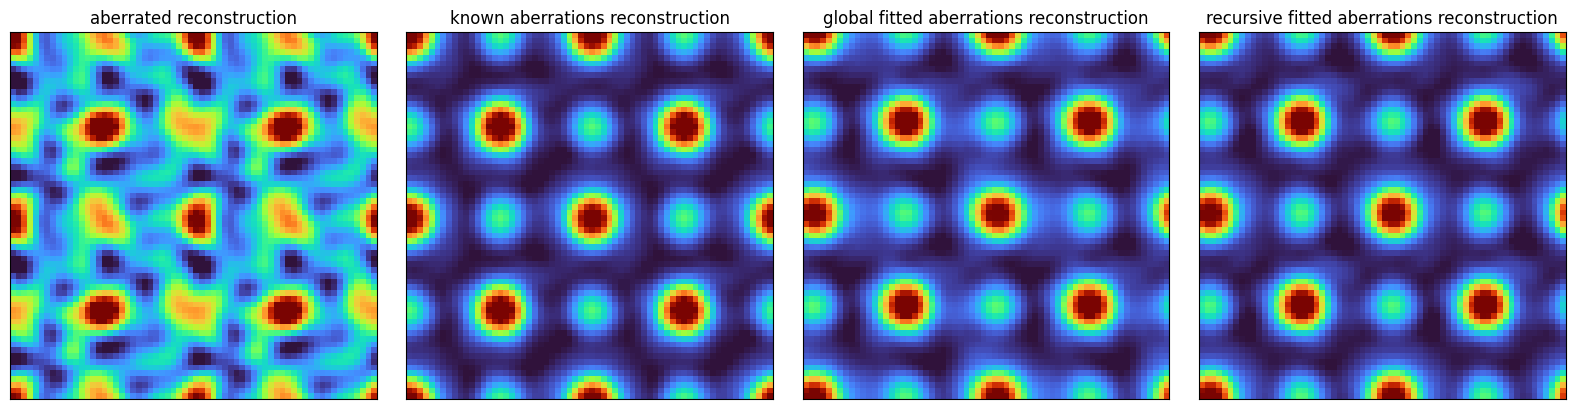

In [23]:
fig, axs = plt.subplots(1,4,figsize=(16,4))

for ax, arr, title in zip(
    axs,
    (reconstructed_object_aberrated,reconstructed_object_known,reconstructed_object_fitted,reconstructed_object_fitted_recursive),
    ('aberrated reconstruction','known aberrations reconstruction','global fitted aberrations reconstruction','recursive fitted aberrations reconstruction')
):
    py4DSTEM.show(
        np.tile(np.angle(arr),(2,2)),
        figax=(fig,ax),
        cmap='turbo',
        ticks=False,
        title=title,
    )

fig.tight_layout()